# NMF topic model 

In this assessment, we study the **Non-negative Matrix Factorisation(NMF)** topic model, which will be explained in detail in the individual reflection. 

The data studied is the email text, which is in the '[Data/All enron unzip](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Data/All%20enron%20unzip)' folder.

This report is divided into the following parts：

1. Date importing and EDA

2. Data Cleaning

3. TF-IDF and dictionary

4. NMF model

5. Parameter study

6. Classification

7. References

In [1]:
import numpy as np
import pandas as pd
import re
import operator
import pickle
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import nltk
from nltk.corpus import wordnet as wn
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(2021)

## 1. Date importing and EDA

The data of this assessment is tens of thousands of emails, each email is a txt file, which is placed in different folders. Now we need to read them, and treat each txt file (ie each email) as an element of the list or data frame. 

In [2]:
##The following address is the file storage location of my github desktop, please change it to your data storage address.

corpus = []
for path in Path(r'C:\Users\xiao\Documents\GitHub\DST-Assessment-3\Data\All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

In [3]:
df = pd.DataFrame(corpus)
df.columns = ['E-mails']

In [4]:
len(df)

27721

In [5]:
df.head(10)

,E-mails
0,Legitimate\n----------\n- Owner: farmer-d\n- T...
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...
5,Subject: meter 7268 nov allocation\nfyi .\n- -...
6,"Subject: mcmullen gas for 11 / 99\njackie ,\ns..."
7,"Subject: meter 1517 - jan 1999\ngeorge ,\ni ne..."
8,Subject: duns number changes\nfyi\n- - - - - -...
9,Subject: king ranch\nthere are two fields of g...


A total of 27721 txt files has been read, but please note that this contains 5 'Summary.txt', we need to delete them.

In [6]:
df = df.drop([0,5173,11031,16544,21720]) # removing unnecessary entries
nlist = np.arange(0,27717,1) # reindexing
df = df.reindex(nlist)
df = df.drop(0)

In [7]:
len(df)

27716

In [8]:
df.head(10)

,E-mails
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...
5,Subject: meter 7268 nov allocation\nfyi .\n- -...
6,"Subject: mcmullen gas for 11 / 99\njackie ,\ns..."
7,"Subject: meter 1517 - jan 1999\ngeorge ,\ni ne..."
8,Subject: duns number changes\nfyi\n- - - - - -...
9,Subject: king ranch\nthere are two fields of g...
10,Subject: re : entex transistion\nthanks so muc...


Finally, we read the contents of 27716 emails, which will be the object of our data analysis.

These emails are classified as normal emails or spam, and then we mark them below, spam is 0 and normal email is 1. 

In [9]:
z1 = np.arange(3673,5173)
z2 = np.arange(9534,11031)
z3 = np.arange(15043,16544)
z4 = np.arange(18043,21719)
z5 = np.arange(23220,27716)
ze = np.concatenate((z1,z2,z3,z4,z5))

In [10]:
z = np.zeros(27716)
df['label'] = z
for i in ze:
    df.iloc[i,1] = 1

In [11]:
df

,E-mails,label
1,Subject: christmas tree farm pictures\n,0.0
2,"Subject: vastar resources , inc .\ngary , prod...",0.0
3,Subject: calpine daily gas nomination\n- calpi...,0.0
4,Subject: re : issue\nfyi - see note below - al...,0.0
5,Subject: meter 7268 nov allocation\nfyi .\n- -...,0.0
...,...,...
27712,Subject: make big bucks in the medical field b...,1.0
27713,"Subject: proposal\ndear sir ,\nfirst i must so...",1.0
27714,"Subject: cure premature ejaculation\nhello ,\n...",1.0
27715,Subject: need your vics ?\nbrand name meds suc...,1.0


Then we add the index.

In [12]:
df['index'] = df.index

In [13]:
df.head(10)

,E-mails,label,index
1,Subject: christmas tree farm pictures\n,0.0,1
2,"Subject: vastar resources , inc .\ngary , prod...",0.0,2
3,Subject: calpine daily gas nomination\n- calpi...,0.0,3
4,Subject: re : issue\nfyi - see note below - al...,0.0,4
5,Subject: meter 7268 nov allocation\nfyi .\n- -...,0.0,5
6,"Subject: mcmullen gas for 11 / 99\njackie ,\ns...",0.0,6
7,"Subject: meter 1517 - jan 1999\ngeorge ,\ni ne...",0.0,7
8,Subject: duns number changes\nfyi\n- - - - - -...,0.0,8
9,Subject: king ranch\nthere are two fields of g...,0.0,9
10,Subject: re : entex transistion\nthanks so muc...,0.0,10


In [14]:
example1 = df[df['index'] == 4].values[0][0]
example1

'Subject: re : issue\nfyi - see note below - already done .\nstella\n- - - - - - - - - - - - - - - - - - - - - - forwarded by stella l morris / hou / ect on 12 / 14 / 99 10 : 18\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\nfrom : sherlyn schumack on 12 / 14 / 99 10 : 06 am\nto : stella l morris / hou / ect @ ect\ncc : howard b camp / hou / ect @ ect\nsubject : re : issue\nstella ,\nthis has already been taken care of . you did this for me yesterday .\nthanks .\nhoward b camp\n12 / 14 / 99 09 : 10 am\nto : stella l morris / hou / ect @ ect\ncc : sherlyn schumack / hou / ect @ ect , howard b camp / hou / ect @ ect , stacey\nneuweiler / hou / ect @ ect , daren j farmer / hou / ect @ ect\nsubject : issue\nstella ,\ncan you work with stacey or daren to resolve\nhc\n- - - - - - - - - - - - - - - - - - - - - - forwarded by howard b camp / hou / ect on 12 / 14 / 99 09 : 08\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\nfrom : sherlyn schumack 12 / 13 / 99 01 : 14 pm\n

Selecting the content of one of the emails, we find that the content is very complicated, which includes various English words, numbers and symbols. In the next part, we will clean the data to make the topic model get better results.

## 2. Data Cleaning

First, we remove the symbols in the text, which is completely unnecessary to consider in the topic model. 

In [15]:
df['E-mails'] = [re.sub(r'[^\w\s]','',str(x)) for x in df['E-mails']]

In [16]:
example2 = df[df['index'] == 4].values[0][0]
example2

'Subject re  issue\nfyi  see note below  already done \nstella\n                      forwarded by stella l morris  hou  ect on 12  14  99 10  18\nam                           \nfrom  sherlyn schumack on 12  14  99 10  06 am\nto  stella l morris  hou  ect  ect\ncc  howard b camp  hou  ect  ect\nsubject  re  issue\nstella \nthis has already been taken care of  you did this for me yesterday \nthanks \nhoward b camp\n12  14  99 09  10 am\nto  stella l morris  hou  ect  ect\ncc  sherlyn schumack  hou  ect  ect  howard b camp  hou  ect  ect  stacey\nneuweiler  hou  ect  ect  daren j farmer  hou  ect  ect\nsubject  issue\nstella \ncan you work with stacey or daren to resolve\nhc\n                      forwarded by howard b camp  hou  ect on 12  14  99 09  08\nam                           \nfrom  sherlyn schumack 12  13  99 01  14 pm\nto  howard b camp  hou  ect  ect\ncc \nsubject  issue\ni have to create accounting arrangement for purchase from unocal energy at\nmeter 986782  deal not tracke

As shown above, for the same example, there are no symbols after processing. Please note that'/n' means line break, is not the real content. 

Then we will need the stopwords from NLTK  for text pre-processing.

In [17]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

We have already downloaded the stopwords. Let’s import them and make it available in 'en_stop'. By the way, because these texts are emails,'subject' is also considered as a stop word. 

In [18]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop.append('Subject')
#en_stop.append('enron')

In [19]:
## a lemma lookup and word standardization

def get_lemma(word):   
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [20]:
## date cleaning

def prepare_text(text):
    tokens = nltk.word_tokenize(text) # Divide sentences into words
    tokens = [token for token in tokens if len(token) > 3] # Only keep words longer than 3
    tokens = [token for token in tokens if token not in en_stop] # Only keep words that are not stop words 
    tokens = [get_lemma(token) for token in tokens]
    return tokens

After preparing the function, we perform data cleaning.

In [21]:
text = df['E-mails']

In [22]:
text

1                   Subject christmas tree farm pictures\n
2        Subject vastar resources  inc \ngary  producti...
3        Subject calpine daily gas nomination\n calpine...
4        Subject re  issue\nfyi  see note below  alread...
5        Subject meter 7268 nov allocation\nfyi \n     ...
                               ...                        
27712    Subject make big bucks in the medical field ba...
27713    Subject proposal\ndear sir \nfirst i must soli...
27714    Subject cure premature ejaculation\nhello \ndi...
27715    Subject need your vics \nbrand name meds such ...
27716    Subject   iso  8859  1  q  good _ news _ c  ed...
Name: E-mails, Length: 27716, dtype: object

In [23]:
text_new = df['E-mails'].map(prepare_text)

In [24]:
text_new

1                         [christmas, tree, farm, picture]
2        [vastar, resource, gary, production, high, isl...
3        [calpine, daily, nomination, calpine, daily, n...
4        [issue, note, already, do, stella, forward, st...
5        [meter, 7268, allocation, forward, lauri, alle...
                               ...                        
27712    [make, buck, medical, field, bait, excel, prob...
27713    [proposal, dear, first, must, solicit, strict,...
27714    [cure, premature, ejaculation, hello, ejaculat...
27715    [need, vics, brand, name, med, vics, vals, xan...
27716    [8859, good, news, edaliss, edumm, eoggra, hel...
Name: E-mails, Length: 27716, dtype: object

By comparing 'text' and 'text_new', the sentence is divided into words, and according to the cleaning rules, some words are removed. 

The following example (the same email example as before) has also undergone such changes.

In [25]:
example3 = text_new[4]
example3

['issue',
 'note',
 'already',
 'do',
 'stella',
 'forward',
 'stella',
 'morris',
 'sherlyn',
 'schumack',
 'stella',
 'morris',
 'howard',
 'camp',
 'subject',
 'issue',
 'stella',
 'already',
 'take',
 'care',
 'yesterday',
 'thanks',
 'howard',
 'camp',
 'stella',
 'morris',
 'sherlyn',
 'schumack',
 'howard',
 'camp',
 'stacey',
 'neuweiler',
 'daren',
 'farmer',
 'subject',
 'issue',
 'stella',
 'work',
 'stacey',
 'daren',
 'resolve',
 'forward',
 'howard',
 'camp',
 'sherlyn',
 'schumack',
 'howard',
 'camp',
 'subject',
 'issue',
 'create',
 'accounting',
 'arrangement',
 'purchase',
 'unocal',
 'energy',
 'meter',
 '986782',
 'deal',
 'track',
 'volume',
 'deal',
 '114427',
 'expire']

In this way, we have completed the data cleaning, and then we can apply the data to the topic model.

## 3. TF-IDF and dictionary

In order to meet the input requirements of the function in the 'sklearn', we need to change the data format, which means that the cleaned words are recombined into sentences.

In [26]:
text2 = [[' '.join(i)] for i in text_new]
df2 = pd.DataFrame(text2)
df2.columns = ['E-mails']
df2

,E-mails
0,christmas tree farm picture
1,vastar resource gary production high island la...
2,calpine daily nomination calpine daily nomination
3,issue note already do stella forward stella mo...
4,meter 7268 allocation forward lauri allen kimb...
...,...
27711,make buck medical field bait excel problem see...
27712,proposal dear first must solicit strict confid...
27713,cure premature ejaculation hello ejaculate wit...
27714,need vics brand name med vics vals xanies othe...


In [27]:
text_processed = df2['E-mails']
text_processed

0                              christmas tree farm picture
1        vastar resource gary production high island la...
2        calpine daily nomination calpine daily nomination
3        issue note already do stella forward stella mo...
4        meter 7268 allocation forward lauri allen kimb...
                               ...                        
27711    make buck medical field bait excel problem see...
27712    proposal dear first must solicit strict confid...
27713    cure premature ejaculation hello ejaculate wit...
27714    need vics brand name med vics vals xanies othe...
27715    8859 good news edaliss edumm eoggra hello welc...
Name: E-mails, Length: 27716, dtype: object

When processing text, how to convert the text into a vector that the model can handle? **TF-IDF(term frequency-inverse document frequency)** is one of the solutions to this problem. The importance of a word is proportional to its frequency in the text (TF) and inversely proportional to its frequency in the corpus (IDF).

We use the 'sklearn.feature_extraction.text.TfidfVectorizer' function to calculate TF-IDF. By the way, when building the vocabulary we ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off.

In [28]:
# Set the minimum term-document frequency to 10
vectorizer = TfidfVectorizer(min_df = 10) 
A = vectorizer.fit_transform(text_processed)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 27716 X 14930 document-term matrix


In [29]:
terms = vectorizer.get_feature_names()
len(terms)

14930

We also get the dictionary, which has 14930 distinct terms. And I list a few of them above.

In [30]:
terms[1000:1100]

['amongthe',
 'amonq',
 'amonqthe',
 'amortization',
 'amortize',
 'amount',
 'amphetamine',
 'ample',
 'amplify',
 'amputate',
 'amro',
 'amsterdam',
 'amtrak',
 'amulet',
 'amuse',
 'anadarko',
 'anaheim',
 'anaiog',
 'anal',
 'analgesic',
 'analog',
 'analogous',
 'analogy',
 'analyse',
 'analysis',
 'analyst',
 'analytic',
 'analytical',
 'analytics',
 'analyze',
 'anatol',
 'anax',
 'ancestry',
 'anchor',
 'anchorage',
 'anchorite',
 'ancient',
 'ancillary',
 'andersen',
 'anderson',
 'andmanyother',
 'andre',
 'andrea',
 'andreas',
 'andrei',
 'andrew',
 'andrews',
 'andy',
 'anecdotal',
 'anew',
 'ange',
 'angeies',
 'angel',
 'angela',
 'angeles',
 'angelica',
 'angelides',
 'angelopoulos',
 'anger',
 'angie',
 'angle',
 'anglo',
 'angola',
 'angry',
 'angus',
 'anheuser',
 'aniline',
 'animal',
 'animate',
 'animation',
 'aninherent',
 'aniseikonic',
 'anita',
 'anjam',
 'ankara',
 'anna',
 'anne',
 'annette',
 'annex',
 'annie',
 'anniversary',
 'announce',
 'announcement',
 

 Then we can look at the terms with the highest TF-IDF scores across all documents in the document-term matrix.

In [31]:
## look at the terms with the highest TF-IDF scores across all documents in the document-term matrix

def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

For example, according to the TF-IDF, we can get the top 20 terms. 

In [32]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. enron (1040.71)
02. please (607.10)
03. 2000 (499.62)
04. 2001 (439.48)
05. http (428.72)
06. need (408.94)
07. vince (406.64)
08. would (394.01)
09. company (386.36)
10. subject (385.36)
11. know (370.26)
12. deal (363.22)
13. email (359.49)
14. thanks (352.30)
15. price (348.55)
16. message (347.68)
17. attach (335.99)
18. time (327.86)
19. business (321.66)
20. information (319.20)


## 4. NMF model

**Non-negative Matrix Factorisation (NMF)** is one of the methods for topic model.

### 4.1 Modeling

Now we apply NMF by using 'sklearn' library.

In [33]:
## Generate 10 topics  
k=10

In [34]:
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform(A)
H = model.components_

### 4.2 Output

NMF produces two outputs: W and H.

The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.

In [35]:
W.shape

(27716, 10)

For example, the second document is mainly related to the fifth topic（0.021 is the largest）, but it is also less related to some other topics.

In [36]:
W[1,:].round(3)

array([0.005, 0.008, 0.   , 0.002, 0.021, 0.009, 0.003, 0.   , 0.002,
       0.003])

The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [37]:
H.shape

(10, 14930)

For example, the second topic is related to the second terms in the dictionary, although the association is very small.

In [38]:
H[1,:].round(5)

array([0.e+00, 8.e-05, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00])

And for the term "enron", we see that it is strongly associated with the second topic. Again, in some cases each term can be associated with multiple topics.

In [39]:
term_index = terms.index('enron')
H[:,term_index].round(2)

array([0.31, 3.61, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### 4.3 Topic content

The top ranked terms from the H factor for each topic can give us an insight into the content of that topic. which is often called the topic descriptor.

In [40]:
## extract the descriptor for a specified topic

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

Then we can get the top 10 terms of each topics.

In [41]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: vince, kaminski, would, meeting, subject, 2001, please, thanks, group, louise
Topic 02: enron, 2000, teco, corp, actuals, iferc, daily, request, communications, subject
Topic 03: adobe, software, 2004, professional, studio, windows, macromedia, corel, photoshop, need
Topic 04: company, statement, security, report, investment, stock, within, information, market, price
Topic 05: deal, meter, volume, daren, mmbtu, flow, 2000, sitara, thanks, contract
Topic 06: http, click, email, free, save, receive, viagra, online, remove, order
Topic 07: claim, lottery, program, winning, number, prize, account, international, address, part
Topic 08: logo, business, stationery, offer, competitor, creative, identity, custom, breathing, revamp
Topic 09: hplno, attach, file, hplo, 2001, 2000, hplnl, march, noms, please
Topic 10: website, submit, search, engine, online, visitor, vain, dramatically, sales, stream


In [42]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 18})

For instance, we can also get the top 10 terms of the first topic.

In [43]:
## draw the top terms of a topic 

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="blue", tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=20)
    plt.tight_layout()
    plt.show()

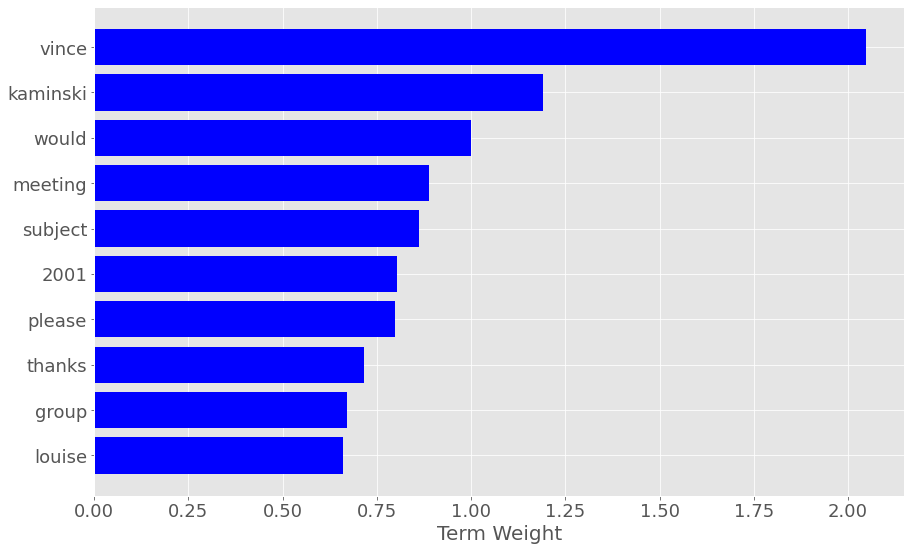

In [44]:
plot_top_term_weights( terms, H, 0, 10 )

## 5. Parameter study

In the topic model, the most important parameter is the number of topics, we now set the number of topics from 2 to 50, and output the model results separately. 

In [45]:
kmin, kmax = 2, 50

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k=42 ...
Applying NMF for k=43 ...
Applying NMF for

**Coherence** and perplexity are the appropriate performance metrics of the topic model to get the optinal parameters. But I didn't find a function to directly calculate them of NMF model in 'sklearn', so we need to write the calculation function ourselves, which is more difficult. Fortunately, I found a reference for coherence. 

This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the '**gensim**' implementation of 'Word2Vec' to build a **Word2Vec** model.

In [46]:
## define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now we build a Word2Vec model using 'gensim'.

In [47]:
docgen = TokenGenerator(text_processed, en_stop)
# the model has 100 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=100, min_count=10, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [48]:
len(w2v_model.wv.vocab)

17698

We can see that model has 17698 terms.

In [49]:
## calculate the coherence of model

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        b = 0
        for pair in combinations( term_rankings[topic_index], 2 ):
            a = w2v_model.similarity(pair[0], pair[1])
            pair_scores.append(a)
            b += a
        # get the mean for all pairs in this topic
        #b = sum(pair_scores)
        c = len(pair_scores)
        topic_score = b/c 
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In this way, we get the function to calculate the coherence, and then calculate and compare all the coherences of the 49 NMF topic models established above. 

In [50]:
k_values = []
coherences = []

for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    a = calculate_coherence( w2v_model, term_rankings )
    coherences.append( a )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=02: Coherence=0.3358
K=03: Coherence=0.3853
K=04: Coherence=0.4025
K=05: Coherence=0.3879
K=06: Coherence=0.3839
K=07: Coherence=0.3884
K=08: Coherence=0.3947
K=09: Coherence=0.4013
K=10: Coherence=0.4148
K=11: Coherence=0.4185
K=12: Coherence=0.4284
K=13: Coherence=0.4218
K=14: Coherence=0.4210
K=15: Coherence=0.4177
K=16: Coherence=0.4235
K=17: Coherence=0.4166
K=18: Coherence=0.4278
K=19: Coherence=0.4281
K=20: Coherence=0.4291
K=21: Coherence=0.4304
K=22: Coherence=0.4364
K=23: Coherence=0.4362
K=24: Coherence=0.4369
K=25: Coherence=0.4322
K=26: Coherence=0.4327
K=27: Coherence=0.4305
K=28: Coherence=0.4374
K=29: Coherence=0.4378
K=30: Coherence=0.4375
K=31: Coherence=0.4399
K=32: Coherence=0.4391
K=33: Coherence=0.4379
K=34: Coherence=0.4340
K=35: Coherence=0.4429
K=36: Coherence=0.4353
K=37: Coherence=0.4423
K=38: Coherence=0.4371
K=39: Coherence=0.4399
K=40: Coherence=0.4348
K=41: Coherence=0.4387
K=42: Coherence=0.4346
K=43: Coherence=0.4319
K=44: Coherence=0.4327
K=45: Coher

In [51]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 10})

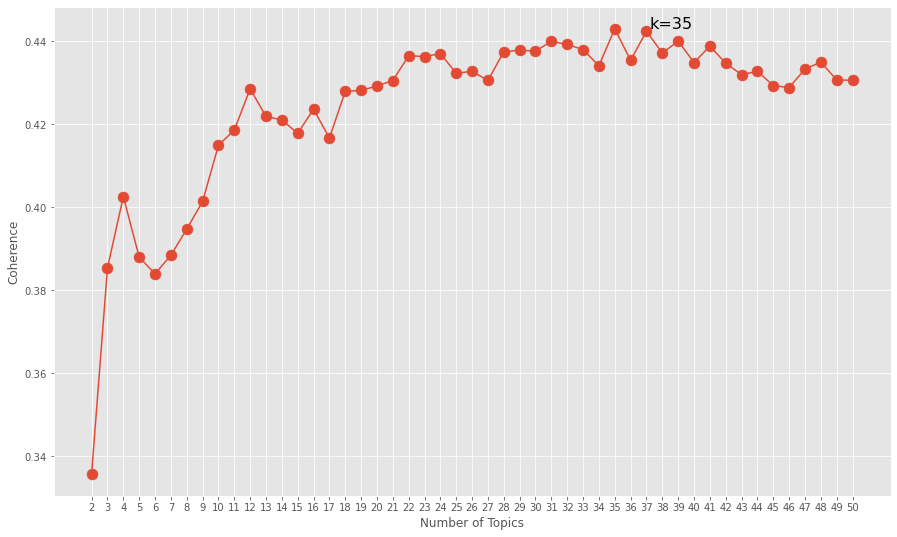

In [52]:
fig = plt.figure(figsize=(15,9))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

The higher the coherence, the better the effect of the topic model.

We can see that when the number of topics is less than 18, the coherence is low, indicating that it is inappropriate to divide such a large amount of email text into a small number of topics. When the number of topics is greater than 18, the coherence is stable in a range. When the number of topics is equal to 35, the coherence is the highest, that is, the topic model works best, so we choose 35 as the number of topics.

### Optinal NMF model

In [53]:
k=35

In [54]:
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform(A)
H = model.components_

In [55]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: vince, kaminski, shirley, crenshaw, research, interview, resume, subject, stinson, would
Topic 02: enron, corp, communications, enronxgate, development, subject, forward, mark, america, mary
Topic 03: software, need, visit, might, site, getting, best, save, popular, money
Topic 04: statement, company, security, within, stock, investment, information, report, advice, news
Topic 05: deal, meter, daren, volume, flow, sitara, ticket, thanks, aimee, contract
Topic 06: online, price, prescription, med, drug, pharmacy, viagra, shipping, cheap, order
Topic 07: claim, lottery, program, winning, prize, international, number, congratulations, part, agent
Topic 08: offer, logo, business, breathing, revamp, artwork, breath, custom, ciick, fresh
Topic 09: website, submit, search, engine, online, visitor, vain, dramatically, sales, stream
Topic 10: louise, kitchen, message, original, sent, subject, john, david, 2002, monday
Topic 11: hplo, file, attach, 2000, june, august, noms, july, sept,

## 6. Classification

Since the input of the topic model is a large number of email texts, they are all different and distinctive. We think that if we divide the  training set and the test set according to the cross-validation method, their distribution may be different. Therefore, we set the test set and training set to entire data to evaluate the classification performance. 

In [56]:
train_x = W
train_y = list(df['label'])
test_x = W
test_y = list(df['label'])

In [57]:
W.shape

(27716, 35)

As mentioned above, the W factor contains the document membership weights relative to each of the k topics, each row corresponds to a single document, and each column correspond to a topic. Using W as the input of the classifier is actually equivalent to reducing the dimensionality of the text so that it only retains k features. 

In the previous assessment, we found that the performance of the decision tree is very good, the classifier is not the focus of this assessment, so we only choose one.

In [58]:
clf_tree = DecisionTreeClassifier(random_state=10)
clf_tree.fit(train_x, train_y)
pre_tree = clf_tree.predict(test_x)
acc_tree = accuracy_score(pre_tree, test_y)
print("------------------------------------------")
print("Accuracy = ",acc_tree*100," %")

------------------------------------------
Accuracy =  99.97835185452446  %


In [59]:
def classification_eval(y_true,y_pred):
    
    print("Confusion Matrix")
    C = confusion_matrix(y_true,y_pred)
    
    print('Classification report')
    print(classification_report(y_true, y_pred, target_names = ['Normal', 'Spam'], digits=5))

In [60]:
classification_eval(test_y,pre_tree)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal    1.00000   0.99960   0.99980     15046
        Spam    0.99953   1.00000   0.99976     12670

    accuracy                        0.99978     27716
   macro avg    0.99976   0.99980   0.99978     27716
weighted avg    0.99978   0.99978   0.99978     27716



We can see that the classifier has a great effect on normal mail and spam. I think this is mainly due to the output W of the NMF model, which is very suitable as the input of various machine learning algorithms, such as decision trees, random forests, SVM, etc.

You can also see in the '[06 -Report.ipynb](https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Report/06%20-Report.ipynb)' that although the NMF model has the lowest coherence, it has the best classification performance. Therefore, I recommend using the method in 'gensim' when studying topic models, and using the NMF topic model in 'sklearn' when focusing more on classification. 

Finally, we save the output result in the '[Data](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Data)' folder. 

In [61]:
pickle.dump(pre_tree, open('Xiao_pred.p','wb'))

In [62]:
pickle.dump(test_y, open('Xiao_actual.p','wb'))

In [64]:
coherences[33]

0.4429066365436902

In [66]:
pickle.dump(coherences[33], open('Xiao_opt_value.p','wb'))

## 7. References

[stop words](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

[workshop in block 07](https://dsbristol.github.io/dst/assets/workshops/block07-TopicModels_part2.ipynb)

[Matt's notebook](https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Matt%20Corrie/Assessment%203.ipynb)

[NMF topic model with Python](https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb)

[NMF topic model](https://iq.opengenus.org/topic-modeling-nmf/)

[sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

[sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

[Coherence calculation function for NMF](https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb)